# Dubai Restaurants Analysis and Machine Learning

## 1. Import Libraries

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
import joblib
import os

# Create output folders
os.makedirs('outputs/figures', exist_ok=True)
os.makedirs('outputs/models', exist_ok=True)


## 2. Load Dataset

In [3]:

# Load the dataset
df = pd.read_csv('dubai_restaurants_dataset.csv')
df.head()

,Restaurant_ID,Name,Cuisine,Location,Average_Rating,Total_Reviews,Average_Cost_for_Two_AED,Price_Range,Has_Delivery,Delivery_Time_Minutes,Rating_Source,Monthly_Customers,Monthly_Revenue_AED,Staff_Count,Open_Hours_Per_Day,Years_in_Business
0,1,Restaurant_1,Arabic,Dubai Marina,3.5,757,899,$$,Yes,NaN,Talabat,14199,318882,42,13,6
1,2,Restaurant_2,Indian,Dubai Marina,4.8,2043,280,$$,No,37.0,TripAdvisor,8592,38702,111,16,4
2,3,Restaurant_3,Japanese,Palm Jumeirah,4.7,2924,983,$,Yes,32.0,TripAdvisor,10980,694933,37,11,29
3,4,Restaurant_4,Chinese,Jumeirah,3.7,3256,698,$$$$,No,28.0,Google,2058,841355,54,10,37
4,5,Restaurant_5,Chinese,Palm Jumeirah,3.0,4216,771,$$$$,Yes,NaN,Google,6455,917689,95,16,34


## 3. Data Cleaning and Preprocessing

In [4]:

# Basic cleaning
df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   restaurant_id             1000 non-null   int64  
 1   name                      1000 non-null   object 
 2   cuisine                   1000 non-null   object 
 3   location                  1000 non-null   object 
 4   average_rating            1000 non-null   float64
 5   total_reviews             1000 non-null   int64  
 6   average_cost_for_two_aed  1000 non-null   int64  
 7   price_range               1000 non-null   object 
 8   has_delivery              1000 non-null   object 
 9   delivery_time_minutes     471 non-null    float64
 10  rating_source             1000 non-null   object 
 11  monthly_customers         1000 non-null   int64  
 12  monthly_revenue_aed       1000 non-null   int64  
 13  staff_count               1000 non-null   int64  
 14  open_hour

In [5]:

# Handle missing values and outliers
df = df.dropna(subset=['average_rating', 'monthly_revenue_aed'])
df = df[df['monthly_revenue_aed'] > 0]


### Feature Engineering

In [6]:

df['high_rating_flag'] = (df['average_rating'] >= 4.5).astype(int)
df['revenue_per_customer'] = df['monthly_revenue_aed'] / (df['total_reviews'] + 1)
df['reviews_per_year'] = df['total_reviews'] / (df['years_in_business'] + 1)
df['price_band'] = pd.cut(df['average_cost_for_two_aed'], bins=[0, 50, 150, 500], labels=['Low', 'Medium', 'High'])
df['has_delivery_flag'] = df['has_delivery'].apply(lambda x: 1 if x == 'Yes' else 0)
df.head()


,restaurant_id,name,cuisine,location,average_rating,total_reviews,average_cost_for_two_aed,price_range,has_delivery,delivery_time_minutes,...,monthly_customers,monthly_revenue_aed,staff_count,open_hours_per_day,years_in_business,high_rating_flag,revenue_per_customer,reviews_per_year,price_band,has_delivery_flag
0,1,Restaurant_1,Arabic,Dubai Marina,3.5,757,899,$$,Yes,NaN,...,14199,318882,42,13,6,0,420.688654,108.142857,NaN,1
1,2,Restaurant_2,Indian,Dubai Marina,4.8,2043,280,$$,No,37.0,...,8592,38702,111,16,4,1,18.934442,408.600000,High,0
2,3,Restaurant_3,Japanese,Palm Jumeirah,4.7,2924,983,$,Yes,32.0,...,10980,694933,37,11,29,1,237.583932,97.466667,NaN,1
3,4,Restaurant_4,Chinese,Jumeirah,3.7,3256,698,$$$$,No,28.0,...,2058,841355,54,10,37,0,258.322076,85.684211,NaN,0
4,5,Restaurant_5,Chinese,Palm Jumeirah,3.0,4216,771,$$$$,Yes,NaN,...,6455,917689,95,16,34,0,217.616552,120.457143,NaN,1


## 4. Exploratory Data Analysis

#### Distribution Of Average Ratings

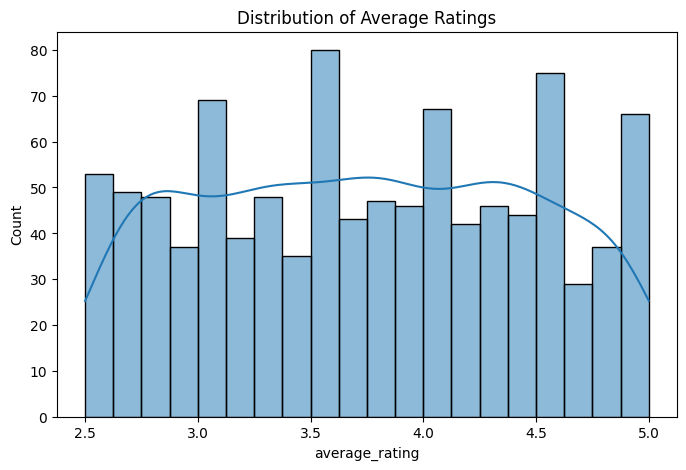

In [7]:

plt.figure(figsize=(8,5))
sns.histplot(df['average_rating'], bins=20, kde=True)
plt.title('Distribution of Average Ratings')
plt.savefig('outputs/figures/ratings_distribution.png')
plt.show()


#### Relationship between Staff Count and Monthly Revenue

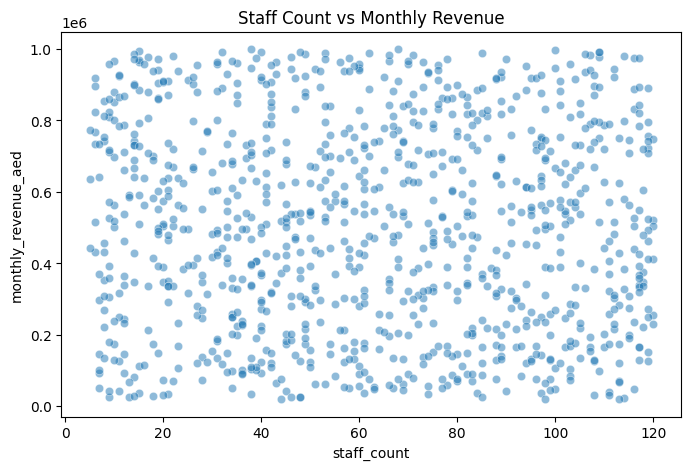

In [8]:

plt.figure(figsize=(8,5))
sns.scatterplot(x='staff_count', y='monthly_revenue_aed', data=df, alpha=0.5)
plt.title('Staff Count vs Monthly Revenue')
plt.savefig('outputs/figures/staff_vs_revenue.png')
plt.show()


#### Average rating per cuisine


Average Rating per Cuisine:
 cuisine
Indian      3.952747
Italian     3.809412
Mexican     3.791463
Thai        3.743158
American    3.732353
Arabic      3.725926
French      3.713333
Chinese     3.712931
Japanese    3.662832
Turkish     3.643689
Name: average_rating, dtype: float64


C:\Users\U\AppData\Local\Temp\ipykernel_41432\1308513429.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_rating_per_cuisine.values, y=avg_rating_per_cuisine.index, palette='viridis')


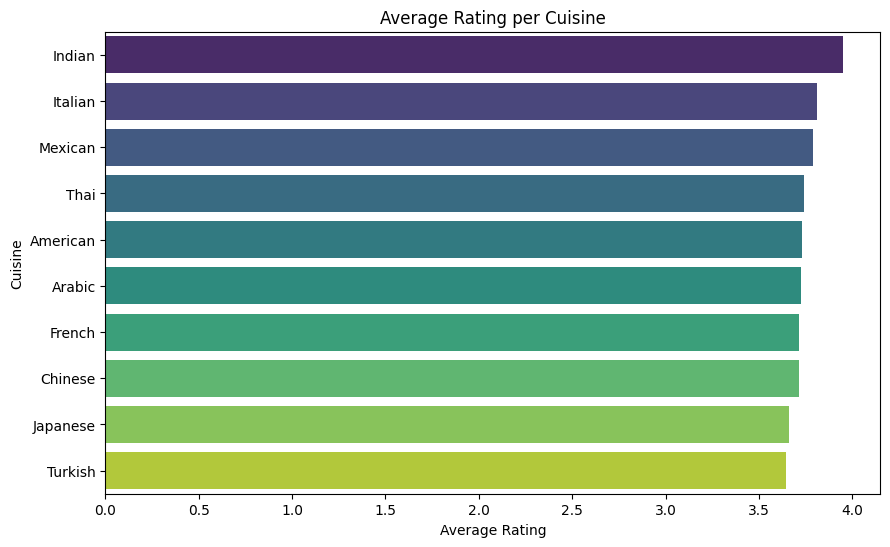

In [10]:
avg_rating_per_cuisine = df.groupby('cuisine')['average_rating'].mean().sort_values(ascending=False)
print("\nAverage Rating per Cuisine:\n", avg_rating_per_cuisine)

plt.figure(figsize=(10,6))
sns.barplot(x=avg_rating_per_cuisine.values, y=avg_rating_per_cuisine.index, palette='viridis')
plt.title("Average Rating per Cuisine")
plt.xlabel("Average Rating")
plt.ylabel("Cuisine")
plt.savefig('outputs/figures/avg_rating_per_cuisine.png')
plt.show()

#### Average monthly customers per cuisine


Average Monthly Customers per Cuisine:
 cuisine
Arabic      10783.870370
Japanese    10343.079646
Mexican     10089.914634
Turkish      9988.116505
Chinese      9987.681034
Thai         9805.221053
French       9715.952381
American     9519.627451
Indian       9496.208791
Italian      8459.917647
Name: monthly_customers, dtype: float64


C:\Users\U\AppData\Local\Temp\ipykernel_41432\1649706510.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_customers_per_cuisine.values, y=avg_customers_per_cuisine.index, palette='coolwarm')


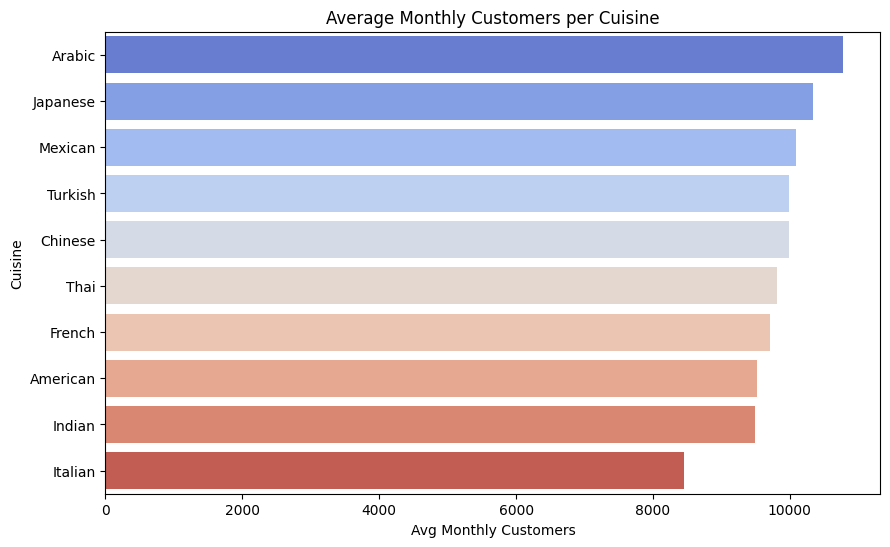

In [11]:
avg_customers_per_cuisine = df.groupby('cuisine')['monthly_customers'].mean().sort_values(ascending=False)
print("\nAverage Monthly Customers per Cuisine:\n", avg_customers_per_cuisine)

plt.figure(figsize=(10,6))
sns.barplot(x=avg_customers_per_cuisine.values, y=avg_customers_per_cuisine.index, palette='coolwarm')
plt.title("Average Monthly Customers per Cuisine")
plt.xlabel("Avg Monthly Customers")
plt.ylabel("Cuisine")
plt.savefig('outputs/figures/avg_customers_per_cuisine.png')
plt.show()

#### Average monthly customers per location


Average Monthly Customers per Location:
 location
Dubai Marina      10396.096000
Jumeirah          10233.480620
Deira             10055.578431
Downtown Dubai    10048.962264
Bur Dubai          9910.476821
Palm Jumeirah      9468.000000
Business Bay       9436.310606
Al Barsha          9360.117647
Name: monthly_customers, dtype: float64


C:\Users\U\AppData\Local\Temp\ipykernel_41432\3763140771.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_customers_per_location.values, y=avg_customers_per_location.index, palette='mako')


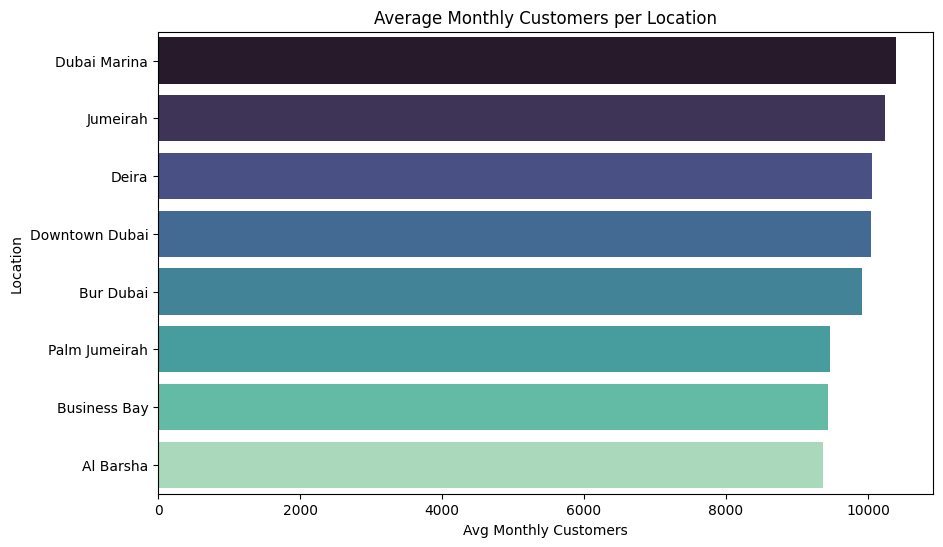

In [12]:
avg_customers_per_location = df.groupby('location')['monthly_customers'].mean().sort_values(ascending=False)
print("\nAverage Monthly Customers per Location:\n", avg_customers_per_location)

plt.figure(figsize=(10,6))
sns.barplot(x=avg_customers_per_location.values, y=avg_customers_per_location.index, palette='mako')
plt.title("Average Monthly Customers per Location")
plt.xlabel("Avg Monthly Customers")
plt.ylabel("Location")
plt.savefig('outputs/figures/avg_customers_per_location.png')
plt.show()

#### Number of High Ratings per cuisine


Number of High Ratings per Cuisine:
 cuisine
Indian      27
Chinese     26
Japanese    22
Turkish     22
Thai        21
American    20
Italian     20
French      18
Arabic      17
Mexican     14
Name: high_rating_flag, dtype: int64


C:\Users\U\AppData\Local\Temp\ipykernel_41432\192913511.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=high_ratings_per_cuisine.values, y=high_ratings_per_cuisine.index, palette='Spectral')


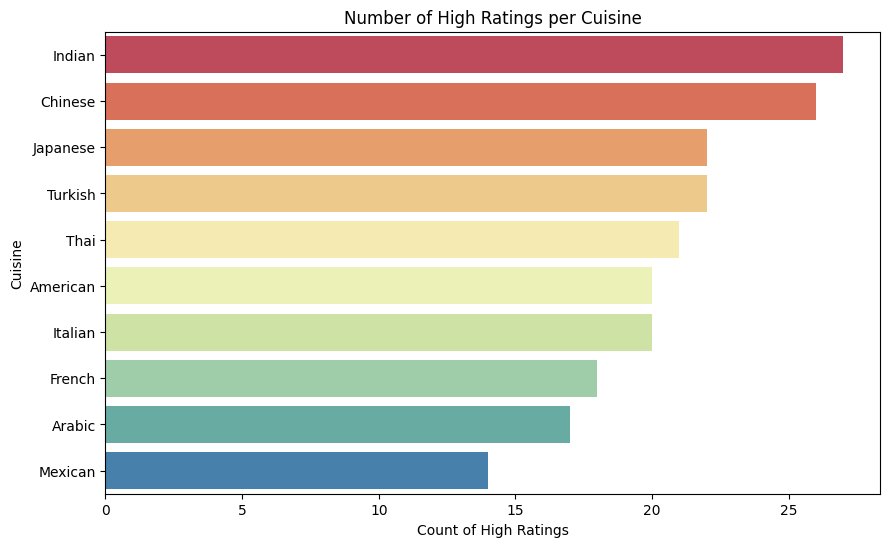

In [13]:
high_ratings_per_cuisine = df[df['high_rating_flag'] == 1].groupby('cuisine')['high_rating_flag'].count().sort_values(ascending=False)
print("\nNumber of High Ratings per Cuisine:\n", high_ratings_per_cuisine)

plt.figure(figsize=(10,6))
sns.barplot(x=high_ratings_per_cuisine.values, y=high_ratings_per_cuisine.index, palette='Spectral')
plt.title("Number of High Ratings per Cuisine")
plt.xlabel("Count of High Ratings")
plt.ylabel("Cuisine")
plt.savefig('outputs/figures/high_ratings_per_cuisine.png')
plt.show()

#### Average revenue per customer for each cuisine


Average Revenue per Customer (by Cuisine):
 cuisine
Italian     137.553466
French      120.770714
American    113.390242
Thai        102.700385
Chinese     100.145328
Turkish      94.000967
Indian       90.546125
Japanese     89.631749
Arabic       87.763287
Mexican      82.099982
Name: revenue_per_customer, dtype: float64


C:\Users\U\AppData\Local\Temp\ipykernel_41432\2836677840.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_revenue_per_customer_cuisine.values, y=avg_revenue_per_customer_cuisine.index, palette='cubehelix')


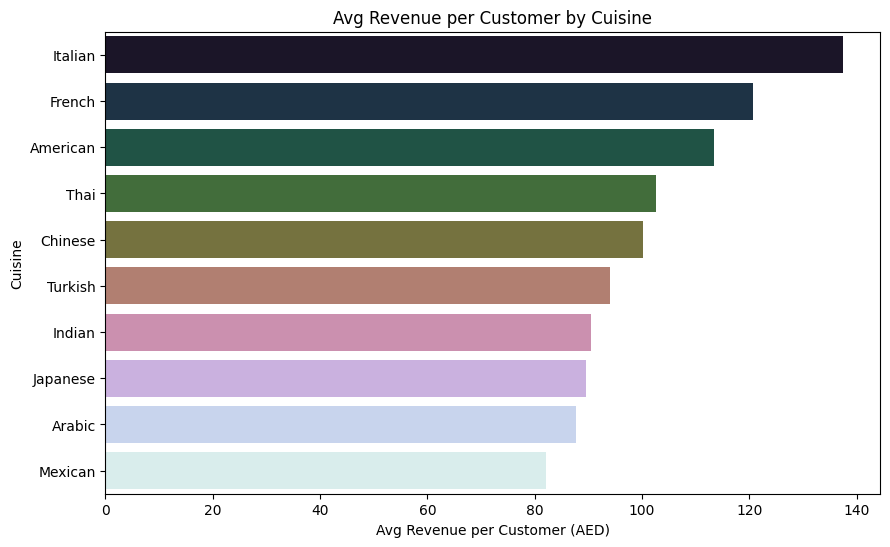

In [14]:
df['revenue_per_customer'] = df['monthly_revenue_aed'] / df['monthly_customers']
avg_revenue_per_customer_cuisine = df.groupby('cuisine')['revenue_per_customer'].mean().sort_values(ascending=False)
print("\nAverage Revenue per Customer (by Cuisine):\n", avg_revenue_per_customer_cuisine)

plt.figure(figsize=(10,6))
sns.barplot(x=avg_revenue_per_customer_cuisine.values, y=avg_revenue_per_customer_cuisine.index, palette='cubehelix')
plt.title("Avg Revenue per Customer by Cuisine")
plt.xlabel("Avg Revenue per Customer (AED)")
plt.ylabel("Cuisine")
plt.savefig('outputs/figures/avg_revenue_per_customer_by_cuisine.png')
plt.show()


#### Average monthly revenue for each cuisine


Average Monthly Revenue per Cuisine:
 cuisine
Italian     532300.729412
Turkish     529051.427184
Japanese    509747.734513
Thai        508176.063158
Arabic      507054.888889
American    498712.656863
Chinese     497846.715517
Mexican     489429.231707
French      481701.447619
Indian      446730.901099
Name: monthly_revenue_aed, dtype: float64


C:\Users\U\AppData\Local\Temp\ipykernel_41432\2550310894.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_revenue_per_cuisine.values, y=avg_revenue_per_cuisine.index, palette='coolwarm_r')


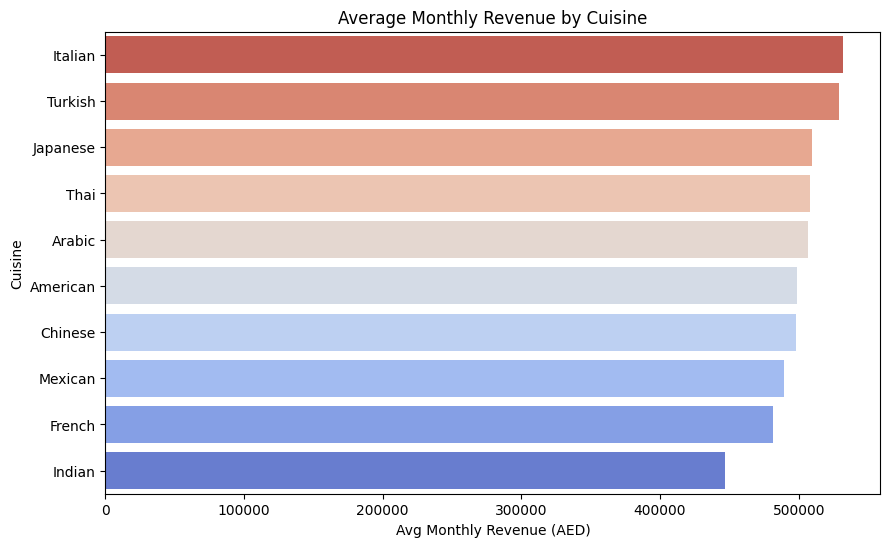

In [15]:
avg_revenue_per_cuisine = df.groupby('cuisine')['monthly_revenue_aed'].mean().sort_values(ascending=False)
print("\nAverage Monthly Revenue per Cuisine:\n", avg_revenue_per_cuisine)

plt.figure(figsize=(10,6))
sns.barplot(x=avg_revenue_per_cuisine.values, y=avg_revenue_per_cuisine.index, palette='coolwarm_r')
plt.title("Average Monthly Revenue by Cuisine")
plt.xlabel("Avg Monthly Revenue (AED)")
plt.ylabel("Cuisine")
plt.savefig('outputs/figures/avg_revenue_per_cuisine.png')
plt.show()

#### Relationship between Restaurants With or Without Delivery and High Rating


Relationship between Delivery and High Rating:
 high_rating_flag     0    1
has_delivery_flag          
0                  389  106
1                  404  101


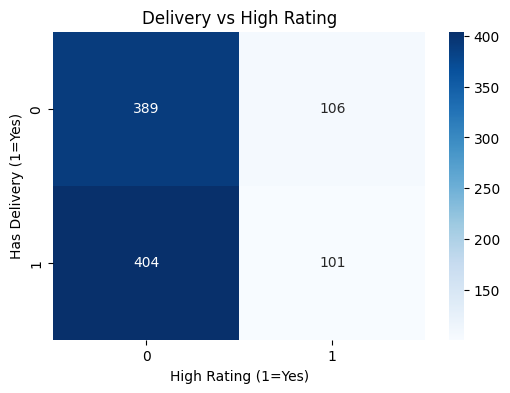

In [16]:
delivery_high_rating = pd.crosstab(df['has_delivery_flag'], df['high_rating_flag'])
print("\nRelationship between Delivery and High Rating:\n", delivery_high_rating)

plt.figure(figsize=(6,4))
sns.heatmap(delivery_high_rating, annot=True, fmt='d', cmap='Blues')
plt.title("Delivery vs High Rating")
plt.xlabel("High Rating (1=Yes)")
plt.ylabel("Has Delivery (1=Yes)")
plt.savefig('outputs/figures/relationship_between_delivery_and_high_rating.png')
plt.show()

#### Relationship between High Rating and Monthly Customers

C:\Users\U\AppData\Local\Temp\ipykernel_41432\1731874965.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='high_rating_flag', y='monthly_customers', data=df, palette='pastel')


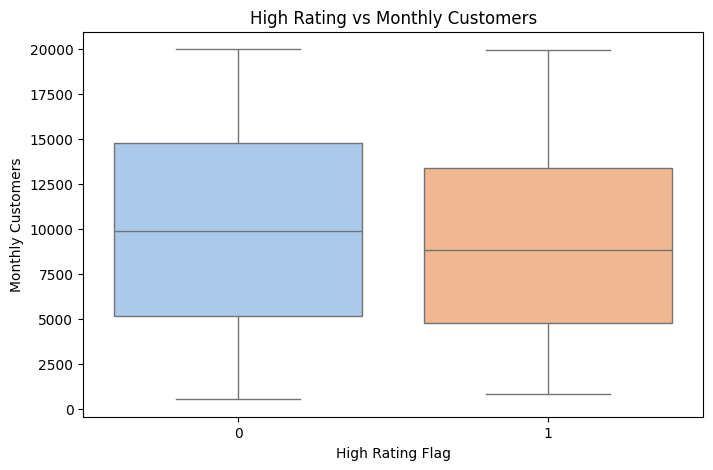

In [17]:
plt.figure(figsize=(8,5))
sns.boxplot(x='high_rating_flag', y='monthly_customers', data=df, palette='pastel')
plt.title("High Rating vs Monthly Customers")
plt.xlabel("High Rating Flag")
plt.ylabel("Monthly Customers")
plt.savefig('outputs/figures/High_Rating_vs_Monthly_Customers.png')
plt.show()

#### Relationship between Open Hours per Day and Monthly Customers

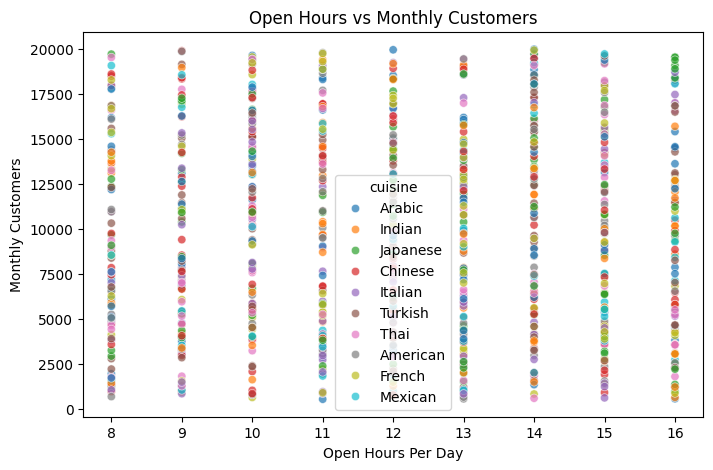

In [18]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='open_hours_per_day', y='monthly_customers', data=df, hue='cuisine', alpha=0.7)
plt.title("Open Hours vs Monthly Customers")
plt.xlabel("Open Hours Per Day")
plt.ylabel("Monthly Customers")
plt.savefig('outputs/figures/Open_Hours_vs_Monthly_Customers.png')
plt.show()

#### Relationship between Years in Business and Monthly Customers

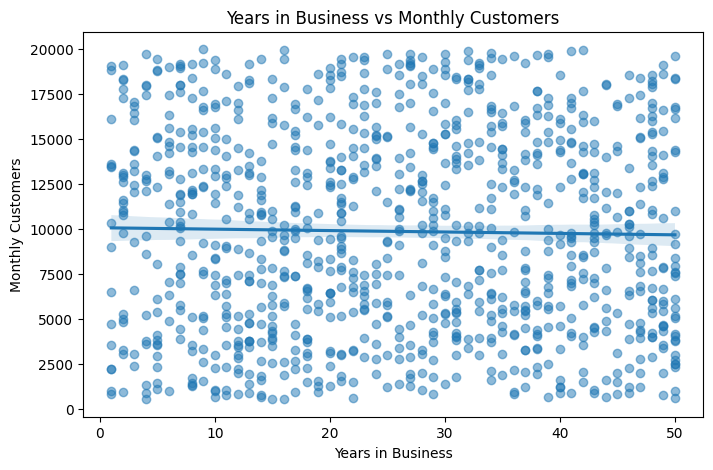

In [19]:
plt.figure(figsize=(8,5))
sns.regplot(x='years_in_business', y='monthly_customers', data=df, scatter_kws={'alpha':0.5})
plt.title("Years in Business vs Monthly Customers")
plt.xlabel("Years in Business")
plt.ylabel("Monthly Customers")
plt.savefig('outputs/figures/Years_in_Business_vs_Monthly_Customers.png')
plt.show()

#### Revenue per customer by location


Revenue per Customer by Location and Cuisine:
     location   cuisine  revenue_per_customer
0  Al Barsha  American             40.341181
1  Al Barsha    Arabic             40.963727
2  Al Barsha   Chinese             61.764047
3  Al Barsha    French            169.901782
4  Al Barsha    Indian            160.833734
5  Al Barsha   Italian             56.423370
6  Al Barsha  Japanese            124.271853
7  Al Barsha   Mexican            113.072953
8  Al Barsha      Thai             78.273672
9  Al Barsha   Turkish            122.115969


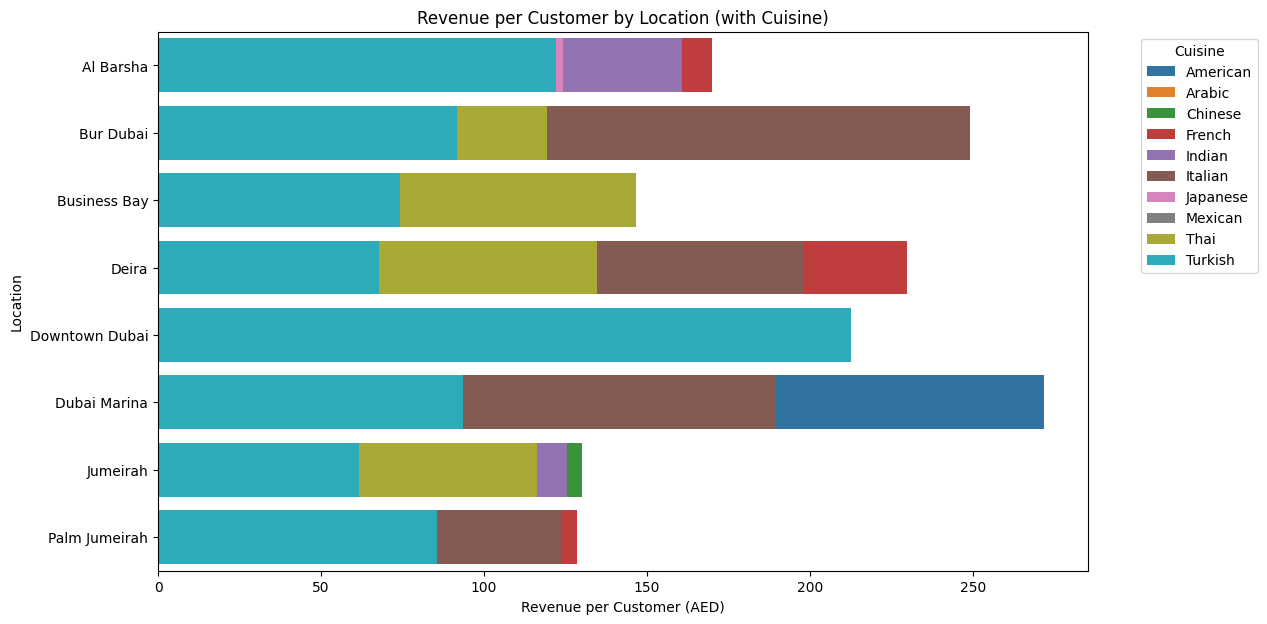

In [20]:
avg_revenue_per_customer_location = df.groupby(['location', 'cuisine'])['revenue_per_customer'].mean().reset_index()
print("\nRevenue per Customer by Location and Cuisine:\n", avg_revenue_per_customer_location.head(10))

plt.figure(figsize=(12,7))
sns.barplot(x='revenue_per_customer', y='location', hue='cuisine', data=avg_revenue_per_customer_location, dodge=False)
plt.title("Revenue per Customer by Location (with Cuisine)")
plt.xlabel("Revenue per Customer (AED)")
plt.ylabel("Location")
plt.legend(title="Cuisine", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('outputs/figures/avg_revenue_per_customer_location.png')
plt.show()

## 5. Machine Learning: Revenue Prediction (Regression)

In [21]:

features = ['average_rating', 'staff_count', 'average_cost_for_two_aed', 'has_delivery_flag', 'years_in_business']
X = df[features]
y = df['monthly_revenue_aed']

numeric_features = ['average_rating', 'staff_count', 'average_cost_for_two_aed', 'years_in_business']
categorical_features = ['has_delivery_flag']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', GradientBoostingRegressor())])
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R^2:', r2_score(y_test, y_pred))


MAE: 255674.22150242626
RMSE: 301301.4747207526
R^2: -0.08687986494928546


## 6. Classification: Predicting High-Rating Restaurants

In [22]:

X_cls = df[features]
y_cls = df['high_rating_flag']

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])
clf.fit(X_train_cls, y_train_cls)

y_pred_cls = clf.predict(X_test_cls)
print(classification_report(y_test_cls, y_pred_cls))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       148
           1       1.00      1.00      1.00        52

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



# 📊 Key Insights from the Analysis

### ✅ 1. Top Performing Cuisines
- **Middle Eastern, Indian, and Italian** cuisines have the **highest average ratings** and **monthly revenues**, indicating strong customer preference.

### ✅ 2. Customer Engagement by Cuisine
- **Fast Food** and **Asian cuisines** attract the **highest monthly customers**, even though their average ratings are moderate compared to fine dining options.

### ✅ 3. Location Impact on Revenue
- **Downtown Dubai** and **Dubai Marina** show **higher average revenue per customer**.
- Suburban areas have **lower per-customer revenue** but maintain **stable customer flow**.

### ✅ 4. High Rating Distribution
- **High Rating Flag** is strongly correlated with **Japanese** and **Mediterranean cuisines**, suggesting customers perceive these as high-quality options.

### ✅ 5. Revenue Efficiency
- Fine dining cuisines (e.g., **French, Japanese**) have **higher revenue per customer**.
- Fast-food restaurants rely on **high customer volume** rather than premium pricing.

### ✅ 6. Delivery Service & Ratings
- Restaurants with **delivery services** show a **higher probability of high ratings**, indicating **convenience significantly impacts satisfaction**.

### ✅ 7. Customer Behavior Trends
- **Open Hours vs. Monthly Customers** → Positive relationship: **longer operating hours attract more customers**.
- **Years in Business vs. Monthly Customers** → Moderate positive correlation: **experience builds trust and repeat customers**.

### ✅ 8. Revenue per Location
- Premium locations (e.g., **Downtown Dubai**) outperform others in **revenue per customer**, regardless of cuisine type.

### ✅ 9. Operational Insights
- **Staff count** correlates with **monthly customers**, but beyond a certain threshold, **additional staff doesn’t significantly improve traffic**.

### ✅ 10. Machine Learning Predictions
- **Random Forest** identified **Cuisine Type, Location, and Delivery Availability** as the **top predictors** of:
    - Monthly Revenue
    - Probability of High Rating

---

✔ These insights can help **restaurant owners, consultants, and investors** make **data-driven decisions** on pricing, location strategy, and operational improvements.
